<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/time_normalise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

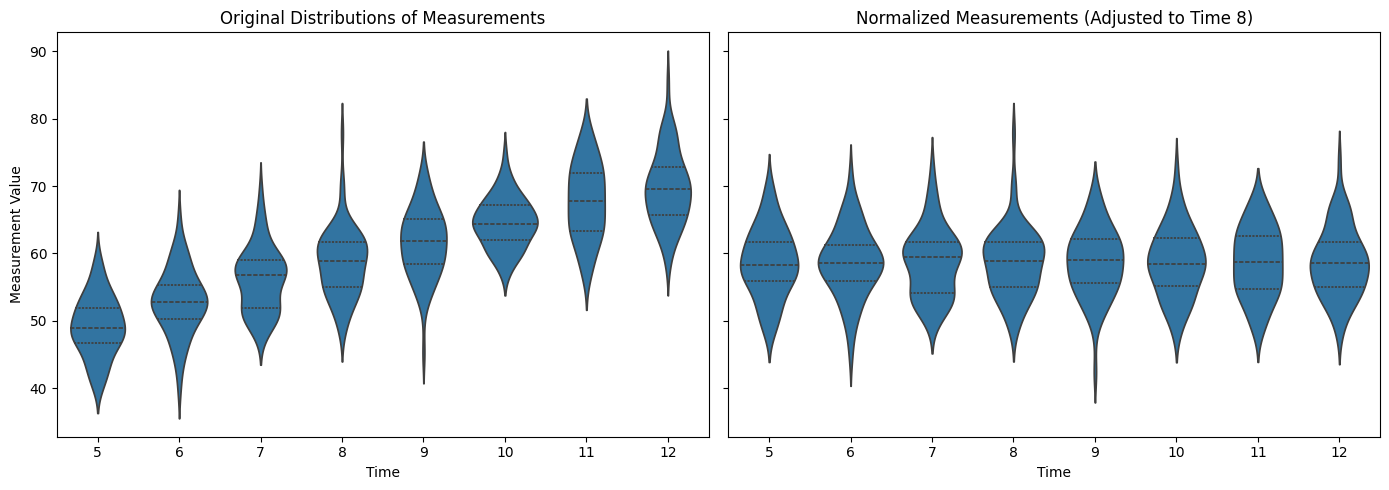

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Generate synthetic data
np.random.seed(42)
n_patients = 500
time_points = np.array([5, 6, 7, 8, 9,10,11,12])  # Discrete time points
mean_trend = np.linspace(50, 70, len(time_points))  # Mean changes over time
std_dev = 5  # Constant standard deviation

# Simulate measurements at different time points
data = []
for t, mu in zip(time_points, mean_trend):
    g_values = np.random.normal(mu, std_dev, size=n_patients // len(time_points))
    for g in g_values:
        data.append([t, g])

df = pd.DataFrame(data, columns=["Time", "Measurement"])

# Fit normal distributions at each time point
fitted_means = []
fitted_stds = []
for t in time_points:
    subset = df[df["Time"] == t]["Measurement"]
    mu, sigma = norm.fit(subset)
    fitted_means.append(mu)
    fitted_stds.append(sigma)

# Choose reference time (e.g., time = 8)
t_ref = 8
mu_ref = fitted_means[list(time_points).index(t_ref)]
sigma_ref = fitted_stds[list(time_points).index(t_ref)]

# Normalize measurements
df["Normalized Measurement"] = df.apply(
    lambda row: (row["Measurement"] - fitted_means[list(time_points).index(row["Time"])]) /
                fitted_stds[list(time_points).index(row["Time"])] * sigma_ref + mu_ref,
    axis=1
)

# Plot original and normalized distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Original distributions
sns.violinplot(x="Time", y="Measurement", data=df, ax=axes[0], inner="quartile")
axes[0].set_title("Original Distributions of Measurements")
axes[0].set_ylabel("Measurement Value")

# Normalized distributions
sns.violinplot(x="Time", y="Normalized Measurement", data=df, ax=axes[1], inner="quartile")
axes[1].set_title(f"Normalized Measurements (Adjusted to Time {t_ref})")
axes[1].set_ylabel("Normalized Measurement Value")

plt.tight_layout()
plt.show()

In [ ]:
# using gmms in case the distribution is more comolex

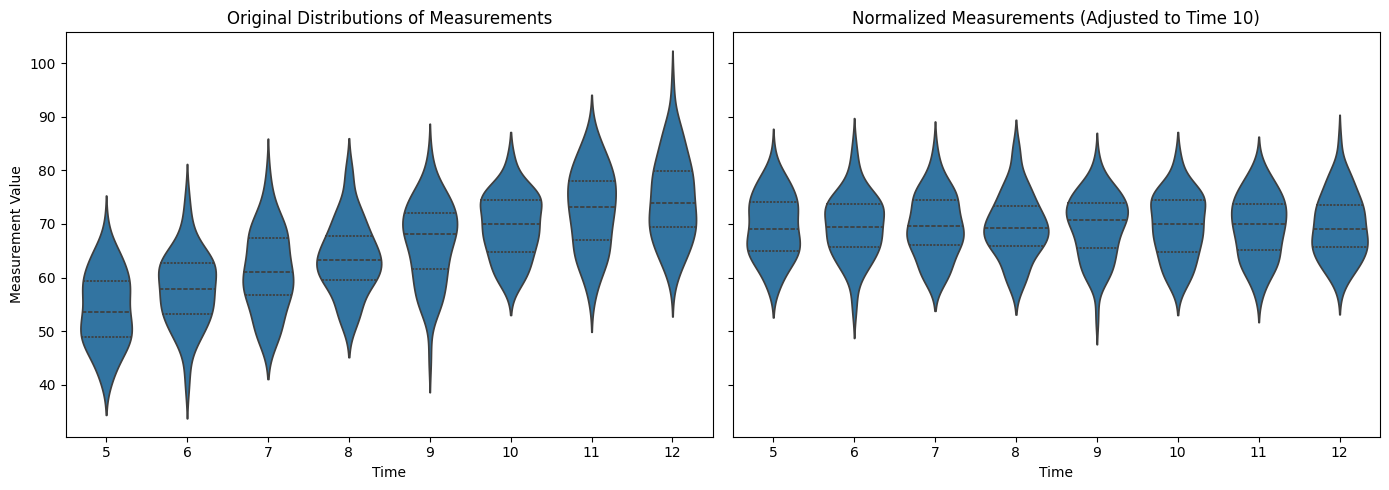

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

# Generate synthetic data
np.random.seed(42)
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])  # Discrete time points
time_points = np.array([5, 6, 7, 8, 9,10,11,12])
mean_trend = np.linspace(50, 70, len(time_points))  # Mean changes over time
std_dev = 5  # Constant standard deviation

# Simulate measurements at different time points with potential multimodal distribution
data = []
for t, mu in zip(time_points, mean_trend):
    # Create two subpopulations at each time point
    g_values_1 = np.random.normal(mu, std_dev, size=n_patients // (2 * len(time_points)))
    g_values_2 = np.random.normal(mu + 10, std_dev, size=n_patients // (2 * len(time_points)))  # Second mode
    g_values = np.concatenate([g_values_1, g_values_2])

    for g in g_values:
        data.append([t, g])

df = pd.DataFrame(data, columns=["Time", "Measurement"])

# Fit GMMs at each time point
n_components = 2  # Assume 2 subpopulations
fitted_means = []
fitted_stds = []

for t in time_points:
    subset = df[df["Time"] == t]["Measurement"].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(subset)

    # Compute the weighted mean and variance
    weights = gmm.weights_
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    weighted_mean = np.sum(weights * means)
    weighted_var = np.sum(weights * (covariances + means**2)) - weighted_mean**2
    weighted_std = np.sqrt(weighted_var)

    fitted_means.append(weighted_mean)
    fitted_stds.append(weighted_std)

# Choose reference time (e.g., time = 10)
t_ref = 10
mu_ref = fitted_means[list(time_points).index(t_ref)]
sigma_ref = fitted_stds[list(time_points).index(t_ref)]

# Normalize measurements
df["Normalized Measurement"] = df.apply(
    lambda row: (row["Measurement"] - fitted_means[list(time_points).index(row["Time"])]) /
                fitted_stds[list(time_points).index(row["Time"])] * sigma_ref + mu_ref,
    axis=1
)

# Plot original and normalized distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Original distributions
sns.violinplot(x="Time", y="Measurement", data=df, ax=axes[0], inner="quartile")
axes[0].set_title("Original Distributions of Measurements")
axes[0].set_ylabel("Measurement Value")

# Normalized distributions
sns.violinplot(x="Time", y="Normalized Measurement", data=df, ax=axes[1], inner="quartile")
axes[1].set_title(f"Normalized Measurements (Adjusted to Time {t_ref})")
axes[1].set_ylabel("Normalized Measurement Value")

plt.tight_layout()
plt.show()

In [ ]:
#generalised form with multiple variables

# **Time-Adjusted Normalization of Multivariate Measurements**

Each patient $i$ has a **single measurement** $g_i \in \mathbb{R}^d$ recorded at a specific time $t_i$. Since measurement distributions change over time, we aim to transform all measurements to a common reference time $t^*$.

## **Mathematical Formulation**
Let:
- $g_i$ be the measurement vector for patient $i$, recorded at time $t_i$.
- $\mu_{t_i}$ and $\Sigma_{t_i}$ be the estimated **mean vector** and **covariance matrix** of $g$ at time $t_i$.
- $\mu_{t^*}$ and $\Sigma_{t^*}$ be the mean and covariance at the **reference time** $t^*$.
- $\Sigma_{t_i}^{-\frac{1}{2}}$ be the **whitening transform**, which removes the covariance structure at $t_i$.
- $\Sigma_{t^*}^{\frac{1}{2}}$ be the **re-scaling transform**, which applies the covariance structure of the reference time $t^*$.

The transformation to adjust $g_i$ to the reference time $t^*$ is given by:

$$
g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}
$$

## **Explanation of Each Term**
1. **Centering the Measurement:**
   $$
   g_i - \mu_{t_i}
   $$
   This removes the mean of the measurements at the original measurement time $t_i$, ensuring that the data is centered around zero.

2. **Whitening the Measurement:**
   $$
   \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})
   $$
   This transforms the data so that it has an identity covariance matrix, effectively removing the correlations present at $t_i$.

3. **Re-scaling to Match the Reference Time:**
   $$
   \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})
   $$
   This applies the covariance structure of the reference time $t^*$.

4. **Restoring the Mean of the Reference Time:**
   $$
   g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}
   $$

---

## **Special Cases**
### **1. Diagonal Covariance Matrices (Uncorrelated Features)**
If the covariance matrices are diagonal, meaning the features are uncorrelated, the transformation simplifies to **scaling each feature independently**:

$$
g_i^* = \frac{(g_i - \mu_{t_i})}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

where $\sigma_{t_i}$ and $\sigma_{t^*}$ are the standard deviations of each feature at times $t_i$ and $t^*$.

### **2. Scalar Case ($g_i$ is 1D)**
If $g_i$ is a scalar rather than a vector, the adjustment simplifies to:

$$
g_i^* = \frac{g_i - \mu_{t_i}}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

---

## **Intuition Behind the Adjustment**
- Each patient **is measured only once at a unique time** $t_i$, meaning we cannot track within-patient changes.
- Instead, we assume that **time affects the statistical distribution** of measurements across patients.
- By transforming all measurements to **match the distribution at $t^*$**, we remove the time-dependent variation, making data comparable.

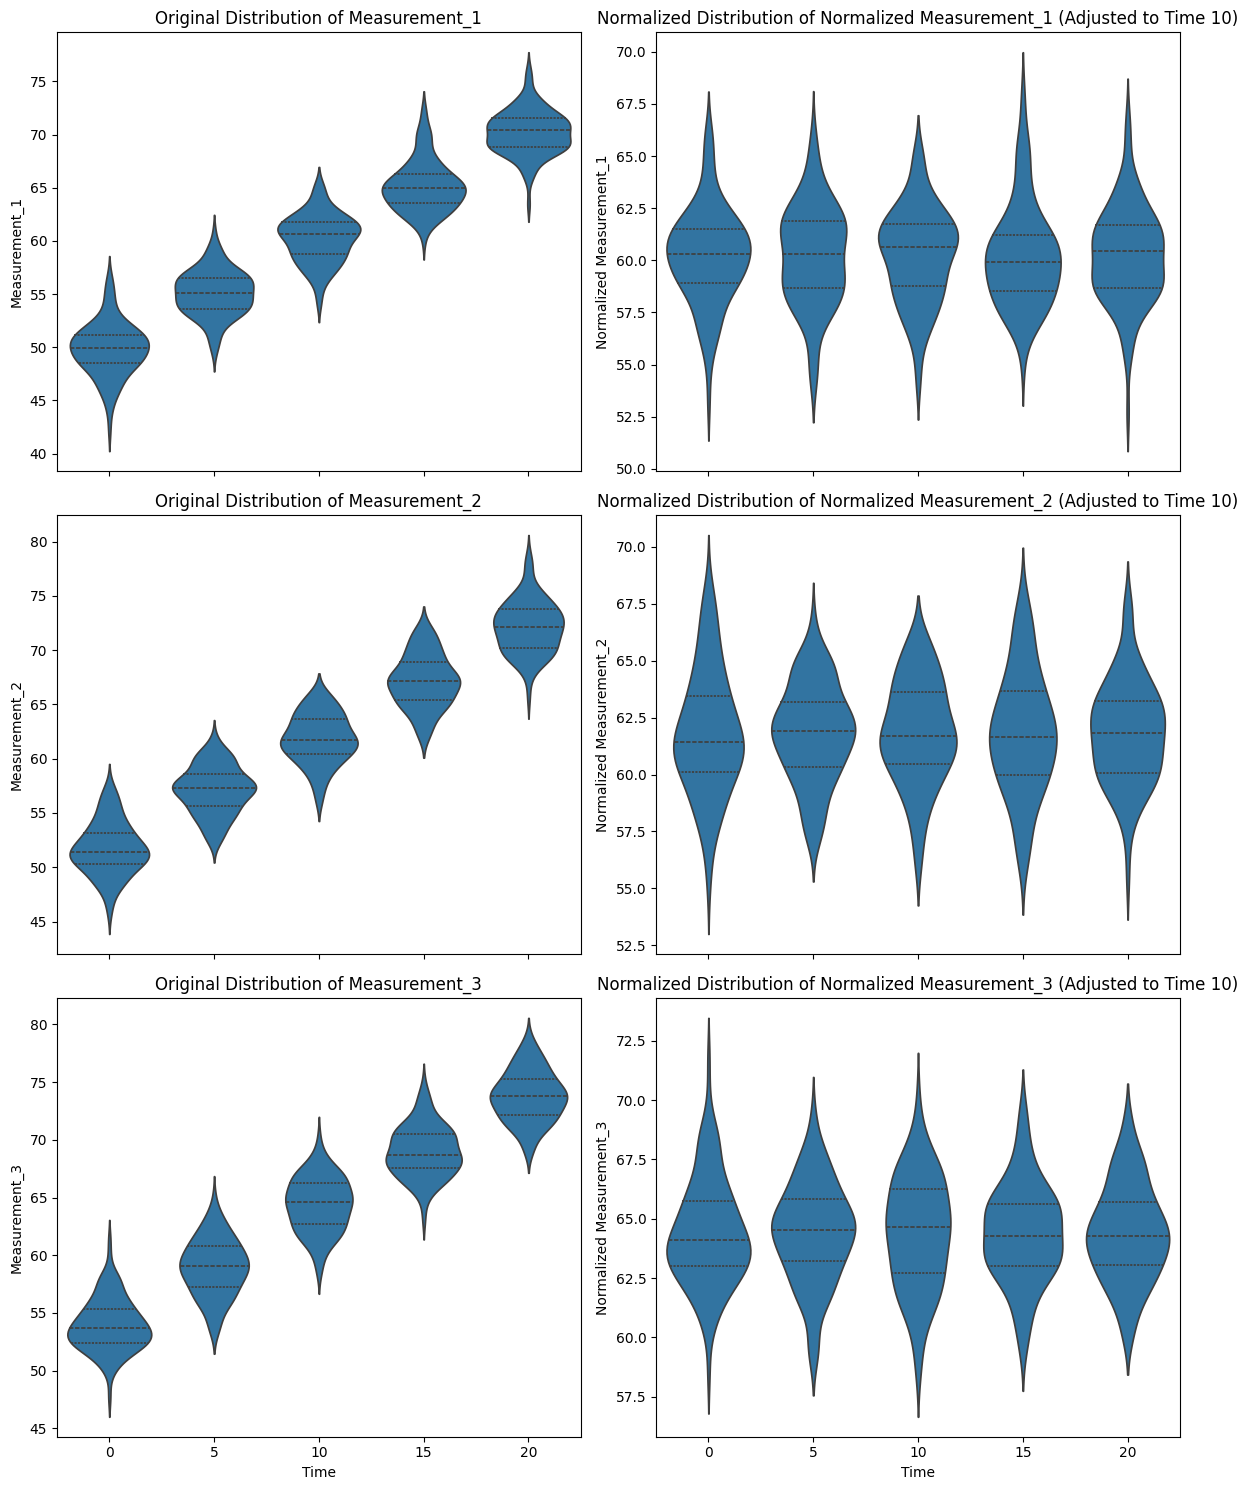

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.linalg import sqrtm, inv

# Generate synthetic multivariate data (each patient has only ONE measurement at a single time)
np.random.seed(42)
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])  # Discrete time points
dim_g = 3  # Number of dimensions in g_i (adjustable)

# Define time-dependent mean trends
mean_trend = np.linspace(50, 70, len(time_points))  # Mean change over time
std_dev = 5  # Standard deviation for each dimension

# Simulate multivariate measurements (each patient has a single measurement at a given time)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)  # Each patient has ONE measurement at a single random time
    mu_t = np.array([mean_trend[list(time_points).index(t)] + i * 2 for i in range(dim_g)])
    cov_t = np.eye(dim_g) * std_dev  # Independent features
    g_i = np.random.multivariate_normal(mu_t, cov_t)  # Single observation
    data.append([t] + list(g_i))

# Create DataFrame
columns = ["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)]
df = pd.DataFrame(data, columns=columns)

# Fit Multivariate GMMs at each time point
n_components = 2  # Assume 2 subpopulations per time point
fitted_means = {}
fitted_covs = {}

for t in time_points:
    subset = df[df["Time"] == t].iloc[:, 1:].values  # Extract measurement columns
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(subset)

    # Compute the weighted mean and covariance
    weights = gmm.weights_
    means = gmm.means_
    covariances = gmm.covariances_

    weighted_mean = np.sum(weights[:, None] * means, axis=0)
    weighted_cov = np.sum(weights[:, None, None] * covariances, axis=0)

    fitted_means[t] = weighted_mean
    fitted_covs[t] = weighted_cov

# Choose reference time (e.g., time = 10)
t_ref = 10
mu_ref = fitted_means[t_ref]
cov_ref = fitted_covs[t_ref]

# Normalize measurements for all dimensions
def normalize_multivariate(row):
    t_i = row["Time"]
    mu_t = fitted_means[t_i]
    cov_t = fitted_covs[t_i]

    # Whitening transform
    whitening_transform = sqrtm(inv(cov_t))
    re_scaling_transform = sqrtm(cov_ref)

    g_original = np.array(row.iloc[1:])  # Extract measurement vector
    g_transformed = re_scaling_transform @ whitening_transform @ (g_original - mu_t) + mu_ref

    return pd.Series(g_transformed)

# Apply normalization
normalized_columns = [f"Normalized Measurement_{i+1}" for i in range(dim_g)]
df[normalized_columns] = df.apply(normalize_multivariate, axis=1)

# Plot original and normalized distributions for each measurement variable
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"
    normalized_col = f"Normalized Measurement_{i+1}"

    # Original distribution
    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")
    axes[i, 0].set_ylabel(measurement_col)

    # Normalized distribution
    sns.violinplot(x="Time", y=normalized_col, data=df, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {normalized_col} (Adjusted to Time {t_ref})")
    axes[i, 1].set_ylabel(normalized_col)

plt.tight_layout()
plt.show()

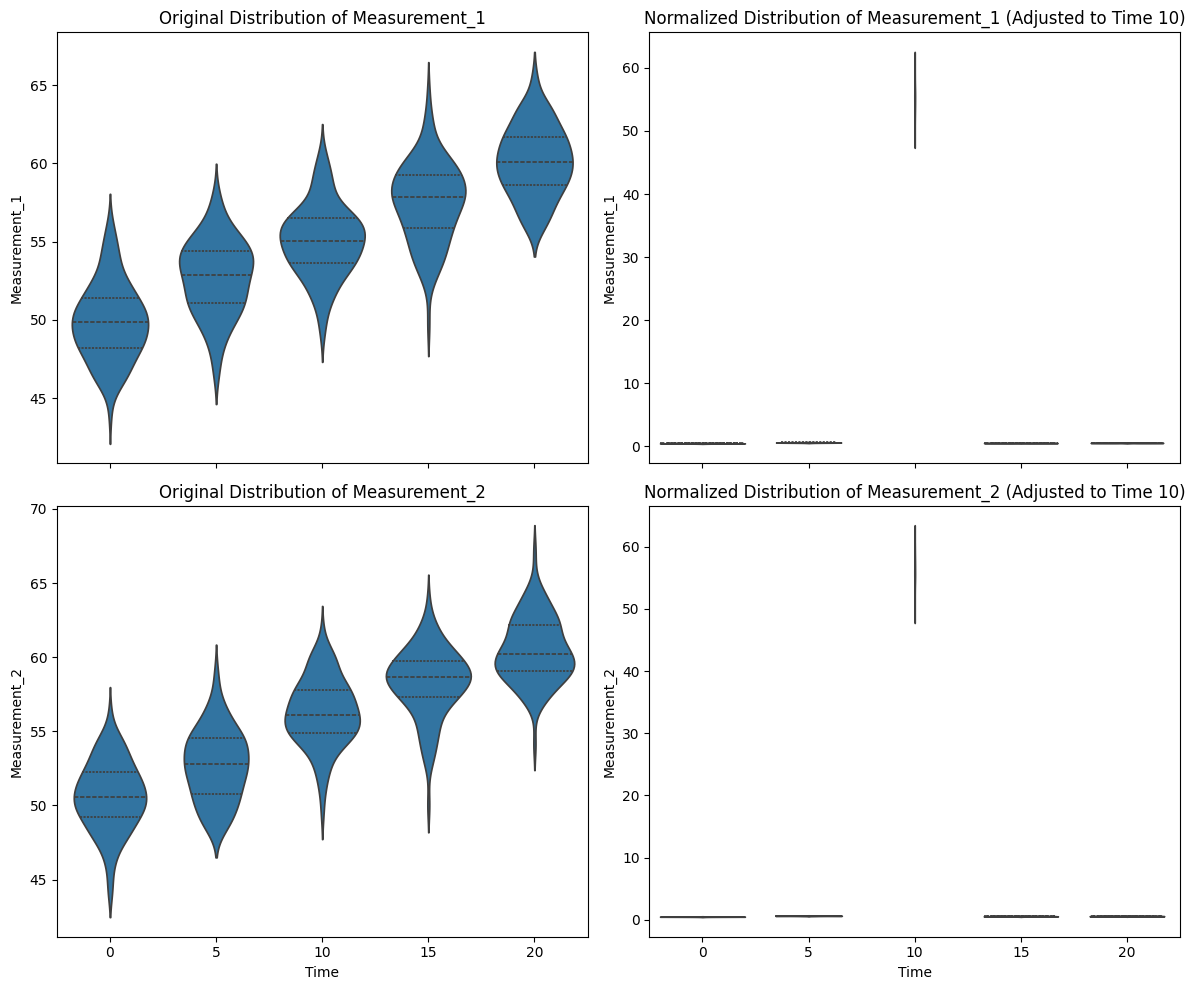

In [18]:
#Using OT - ignore for now
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ot  # POT: Python Optimal Transport

# Generate synthetic data
np.random.seed(42)
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])
dim_g = 2  # Number of dimensions in g_i

# Simulate multivariate measurements (patients measured only once at random time points)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)
    mu_t = np.array([50 + (t / 2) + i * 0.5 for i in range(dim_g)])  # Time-dependent mean
    cov_t = np.eye(dim_g) * 5  # Independent feature variance
    g_i = np.random.multivariate_normal(mu_t, cov_t)
    data.append([t] + list(g_i))

df = pd.DataFrame(data, columns=["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)])

# Select a reference time (e.g., t=10)
t_ref = 10
source_data = df[df["Time"] == t_ref].iloc[:, 1:].values  # Target distribution

# Ensure proper mapping of transported data
transformed_data = df.copy()

for t in time_points:
    if t == t_ref:
        continue  # Skip reference time since we normalize everything to it

    # Extract data for the current time
    target_data = df[df["Time"] == t].iloc[:, 1:].values

    if len(target_data) == 0:
        continue  # Skip if no data for this time

    # Compute cost matrix (Euclidean distance)
    cost_matrix = ot.dist(target_data, source_data, metric="euclidean")

    # Define uniform weights for both distributions
    n_source, n_target = len(source_data), len(target_data)
    a, b = np.ones(n_target) / n_target, np.ones(n_source) / n_source  # Equal weights

    # Compute Optimal Transport plan
    transport_plan = ot.emd(a, b, cost_matrix)  # Solve OT problem

    # Compute transported samples via Barycentric Projection
    mapped_data = transport_plan @ source_data  # Move target data towards reference

    # Directly replace transformed data without additional standardization
    transformed_data.loc[df["Time"] == t, df.columns[1:]] = mapped_data

# Plot original and normalized distributions
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"

    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")

    sns.violinplot(x="Time", y=measurement_col, data=transformed_data, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {measurement_col} (Adjusted to Time {t_ref})")

plt.tight_layout()
plt.show()